In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from single_photons.simulation.simulation_particle import simulation
import single_photons.utils.constants as ct
from single_photons.environment import Particle
from single_photons.utils.parameters import *

In [2]:
omega = 2*np.pi*1e5
T = 2*np.pi/omega
t = np.arange(0, 1000*T, T/400)
N = t.shape[0]
std_detection = 1
p = 0
radius = 75e-9
wavelength = 1.064e-6
power = 300e-3
waist = 0.6e-6
eta_detection = 0.178
delta_t = 1e-9
control_step = 30 
fs = 1/(control_step*delta_t)
gamma, omega, ba_force, std_detection, std_z = compute_parameters_simulation(power, wavelength, waist, 
                                                                      radius, p, fs, eta_detection)
coupling = (1/(4*np.pi))*(ba_force**2)
env = Particle(omega, gamma, coupling, eta_detection=eta_detection)
variance_process = env.thermal_force_std**2 + env.backaction_std**2
std_detection = std_detection/env.zp_x
period = 2*np.pi/omega
t = np.arange(0, 20 * period, delta_t)
N = t.shape[0]


In [3]:
Q = np.array([[0, 0], [0, variance_process]])*control_step*delta_t/2
R = np.array([[np.power(std_detection,2)]])

In [4]:
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step

In [5]:
x0 = 0
P0 = 3e8
new_states, measured_states, estimated_states, cov_aposteriori = simulation(
    env.__omega__,
    env.__gamma__, 
    env.thermal_force_std-env.backaction_std, 
    std_detection, 
    x0, 
    P0, 
    Ad, 
    Bd, 
    env.C, 
    np.zeros((1,2)),
    Q, 
    R, 
    delta_t, 
    control_step, 
    N
)

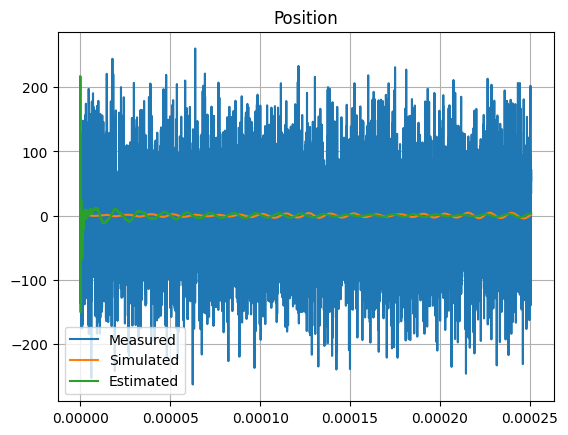

In [6]:
fig = plt.Figure()
plt.title('Position')
plt.plot(t, measured_states[:])
plt.plot(t, new_states[:,0])
plt.plot(t, estimated_states[:,0])
plt.grid()
plt.legend(['Measured', 'Simulated', 'Estimated'])
plt.show()

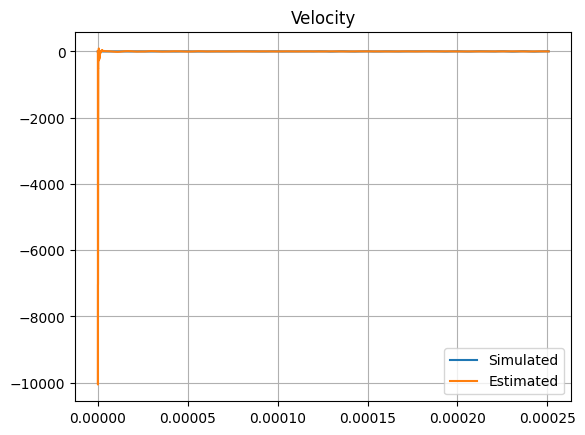

In [7]:
fig = plt.Figure()
plt.title('Velocity')
plt.plot(t[:], new_states[:,1])
plt.plot(t[:], estimated_states[:,1])
plt.grid()
plt.legend(['Simulated', 'Estimated'])
plt.show()

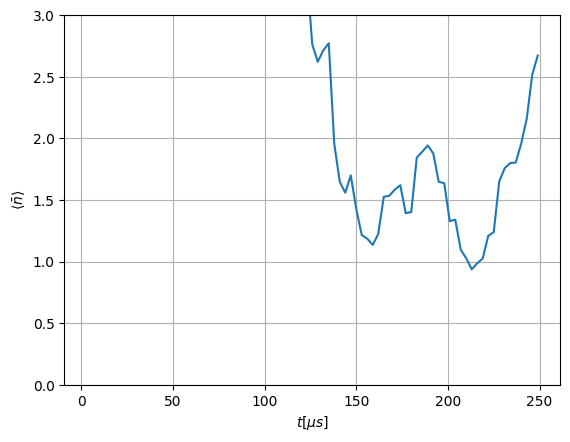

In [8]:
step=100
phonons = compute_phonons(estimated_states[::control_step, :], cov_aposteriori, step=step)
plt.plot(t[::control_step][::step][1:]/1e-6, phonons)
plt.ylabel(r'$\langle \bar{n} \rangle$')
plt.xlabel(r'$t[\mu s]$')
plt.grid()
plt.ylim([0,3])
plt.show()